# Original Dataset - Random Forest Classifier

In [35]:
# Import dependencies
import sqlalchemy
from sqlalchemy import create_engine, inspect

import pandas as pd
import numpy as np
import os
import time
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score

import joblib
import matplotlib.pyplot as plt

%run functions.ipynb

In [2]:
# Time the run
start_time = time.time()

In [3]:
# Import the data
engine = create_engine("sqlite:///voice.sqlite")

# View all of the classes
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['alexaval',
 'alexbval',
 'alexgval',
 'alexrval',
 'aval',
 'bval',
 'chroma1',
 'chroma10',
 'chroma11',
 'chroma12',
 'chroma2',
 'chroma3',
 'chroma4',
 'chroma5',
 'chroma6',
 'chroma7',
 'chroma8',
 'chroma9',
 'chromastd',
 'deltachroma1',
 'deltachroma10',
 'deltachroma11',
 'deltachroma12',
 'deltachroma2',
 'deltachroma3',
 'deltachroma4',
 'deltachroma5',
 'deltachroma6',
 'deltachroma7',
 'deltachroma8',
 'deltachroma9',
 'deltachromastd',
 'deltaenergy',
 'deltaenergyentropy',
 'deltamfcc1',
 'deltamfcc10',
 'deltamfcc11',
 'deltamfcc12',
 'deltamfcc13',
 'deltamfcc2',
 'deltamfcc3',
 'deltamfcc4',
 'deltamfcc5',
 'deltamfcc6',
 'deltamfcc7',
 'deltamfcc8',
 'deltamfcc9',
 'deltaspectralcentroid',
 'deltaspectralentropy',
 'deltaspectralflux',
 'deltaspectralrolloff',
 'deltaspectralspread',
 'deltazcr',
 'demographic',
 'diagnosis',
 'energy',
 'energyentropy',
 'gval',
 'habits',
 'mfcc1',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5

In [4]:
# Tables to import
import_tables = ['diagnosis', 'demographic', 'habits']

In [5]:
# Initialise a dictionary to hold dataframes
dataframes = dict()

# Loop through each table
for table in import_tables:
    
    # Dataframe name
    df_name = f'{table}_df'
    
    # Create dataframe
    dataframes[df_name] = pd.read_sql(
        f'SELECT * FROM {table}',
        engine
    )

In [6]:
# Merge dataframes
merged_df = pd.merge(
    dataframes['demographic_df'],
    dataframes['diagnosis_df'],
    how = 'inner',
    on = 'id'
)

merged_df = pd.merge(
    merged_df,
    dataframes['habits_df'],
    how = 'inner',
    on = 'id'
)

# Display merged_df
merged_df.head()

,id,age,gender,occupation_status,diagnosis,subtype,vhi_score,rsi_score,reflux_indicated,vhi_zscore,...,chocolate,chocolate_grams_pd,coffee,coffee_pd,citrus_fruits,citrus_fruits_pd,soft_cheese,soft_cheese_pd,tomatoes,water_litres_pd
0,voice100,24,m,unknown,healthy,no subtype,0,5,0,-0.58,...,sometimes,30,always,3,never,0.00,almost always,100,never,1.5
1,voice101,60,m,unknown,healthy,no subtype,80,10,0,4.76,...,sometimes,30,always,4,never,0.00,sometimes,100,sometimes,1.5
2,voice192,22,m,cook,hyperkinetic dysphonia,no subtype,0,10,0,-0.58,...,always,14,always,3,almost always,1.17,sometimes,100,sometimes,2.5
3,voice193,46,f,housewife,hyperkinetic dysphonia,no subtype,0,36,1,-0.58,...,sometimes,30,always,2,sometimes,1.00,sometimes,100,sometimes,1.0
4,voice008,51,f,researcher,reflux laryngitis,no subtype,19,15,1,0.68,...,almost always,20,always,2,almost always,1.00,sometimes,100,almost always,1.0


## Preprocessing

### Separate the target and feature variables

In [7]:
# Drop the 'id' column
no_id_df = merged_df.drop(columns=['id'])

In [8]:
# Define the target variables
target_var = ['diagnosis', 'subtype']
y = no_id_df[target_var]

# Define the feature variables
X = no_id_df.drop(columns=target_var)

### Binary classification - `diagnosis`

In [9]:
# Encode the target variable, ignore subtype
y = y['diagnosis'].apply(encode_binary)
y

0      0
1      0
2      1
3      1
4      1
      ..
199    0
200    1
201    1
202    0
203    0
Name: diagnosis, Length: 204, dtype: int64

### Bin `occupation_status` column

In [10]:
# Use limit_unique() function to bin the column
limit_unique(X, 10, ['occupation_status'])

occupation_status
unknown               41
researcher            41
other                 25
employee              25
housewife             23
student               16
technical operator    12
singer                10
pensioner              6
doctor                 5
Name: count, dtype: int64
Number of unique values: 10



### Encode feature columns

In [11]:
# Define the maps
smoker_map = {
    'no': 0,
    'casual': 1,
    'yes': 2
}

alcohol_map = {
    'nondrinker': 0,
    'casual': 1,
    'habitual': 2
}

habit_map = {
    'never': 0,
    'almost never': 1,
    'sometimes': 2,
    'almost always': 3,
    'always': 4
}

In [12]:
# Apply the label encoding using the maps
X['smoker'] = X['smoker'].map(smoker_map)
X['alcohol_consumption'] = X['alcohol_consumption'].map(alcohol_map)

# Habit columns
habit_cols = [
    'carbonated_beverages', 'tomatoes',
    'coffee', 'chocolate',
    'soft_cheese', 'citrus_fruits'
]

# Use a loop for the habit columns
for habit in habit_cols:
    X[habit] = X[habit].map(habit_map)

In [13]:
# Encode the categorical columns using get_dummies
categorical_hot = ['gender', 'occupation_status']

# One-hot encoding
encoded_columns = pd.get_dummies(X[categorical_hot]).astype(int)

# Update the feature dataframe
X.drop(categorical_hot, axis=1, inplace=True)
X = pd.concat([X, encoded_columns], axis=1)

# Convert the 'occupation_status_unknown' to 'occupation_status_other'
X.loc[X['occupation_status_unknown'] == 1, 'occupation_status_other'] = 1

# Drop the 'occupation_status_unknown' column
X = X.drop(columns=['occupation_status_unknown'])

In [14]:
# Display the dataframe
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   204 non-null    int64  
 1   vhi_score                             204 non-null    int64  
 2   rsi_score                             204 non-null    int64  
 3   reflux_indicated                      204 non-null    int64  
 4   vhi_zscore                            204 non-null    float64
 5   vhi_impact                            204 non-null    int64  
 6   alcohol_consumption                   204 non-null    int64  
 7   alcohol_pd                            204 non-null    float64
 8   smoker                                204 non-null    int64  
 9   cigarettes_pd                         204 non-null    int64  
 10  carbonated_beverages                  204 non-null    int64  
 11  carbonated_pd      

,age,vhi_score,rsi_score,reflux_indicated,vhi_zscore,vhi_impact,alcohol_consumption,alcohol_pd,smoker,cigarettes_pd,...,gender_m,occupation_status_doctor,occupation_status_employee,occupation_status_housewife,occupation_status_other,occupation_status_pensioner,occupation_status_researcher,occupation_status_singer,occupation_status_student,occupation_status_technical operator
0,24,0,5,0,-0.58,0,1,0.36,0,0,...,1,0,0,0,1,0,0,0,0,0
1,60,80,10,0,4.76,4,0,0.00,0,0,...,1,0,0,0,1,0,0,0,0,0
2,22,0,10,0,-0.58,0,0,0.00,0,0,...,1,0,0,0,1,0,0,0,0,0
3,46,0,36,1,-0.58,0,1,0.36,2,15,...,0,0,0,1,0,0,0,0,0,0
4,51,19,15,1,0.68,1,1,0.36,0,0,...,0,0,0,0,0,0,1,0,0,0


## Split and Scale

In [15]:
# Split the preprocessed data to training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [16]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Random Forest Model

In [17]:
# Define parameters
n_estimators = 1000
criterion = 'gini'

In [18]:
# Create the random forest classifier instance
forest_model = RandomForestClassifier(
    n_estimators = n_estimators,
    criterion = criterion
)

# Fit the model
forest_model = forest_model.fit(X_train_scaled, y_train)

In [19]:
# Making predictions using the testing data
predictions = forest_model.predict(X_test_scaled)

In [20]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm,
    index = ["Actual 0", "Actual 1"],
    columns = ["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
model_accuracy = accuracy_score(y_test, predictions)

In [21]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"\nAccuracy Score: {model_accuracy}")
print("\nClassification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,8,6
Actual 1,3,34



Accuracy Score: 0.8235294117647058

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.85      0.92      0.88        37

    accuracy                           0.82        51
   macro avg       0.79      0.75      0.76        51
weighted avg       0.82      0.82      0.82        51



In [22]:
# Get the feature importance array
importances = forest_model.feature_importances_

# List the top 10 most important features
sorted(zip(importances, X.columns), reverse=True)

[(0.11542097845797158, 'vhi_zscore'),
 (0.1071401822323452, 'vhi_score'),
 (0.07400491224846756, 'age'),
 (0.0587884244558989, 'rsi_score'),
 (0.05333539583348209, 'carbonated_pd'),
 (0.045949373768318334, 'vhi_impact'),
 (0.0433859431981543, 'citrus_fruits_pd'),
 (0.0426588531998613, 'carbonated_beverages'),
 (0.03874265092911217, 'coffee_pd'),
 (0.03577378354009679, 'water_litres_pd'),
 (0.03516110628815346, 'coffee'),
 (0.0316155529803663, 'citrus_fruits'),
 (0.026281323499221212, 'alcohol_pd'),
 (0.02552534793419063, 'occupation_status_student'),
 (0.024659002447299586, 'chocolate_grams_pd'),
 (0.0236030695899799, 'tomatoes'),
 (0.02357984909512217, 'soft_cheese'),
 (0.021328233888193333, 'chocolate'),
 (0.01783322988141254, 'cigarettes_pd'),
 (0.017381093462359793, 'soft_cheese_pd'),
 (0.01595167481591097, 'alcohol_consumption'),
 (0.0157676648369053, 'gender_m'),
 (0.0148654120015315, 'occupation_status_researcher'),
 (0.013710410598738006, 'reflux_indicated'),
 (0.01361299537371

## Save Results to Performance Tracker

In [23]:
# Extract the precision and recall
precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
print(precision, recall)

[0.72727273 0.85      ] [0.57142857 0.91891892]


In [24]:
# Create dictionary to save the results
results_dict = dict()

current_time = datetime.now()
results_dict['timestamp'] = current_time
results_dict['runtime'] = time.time() - start_time
results_dict['model_accuracy'] = model_accuracy
results_dict['precision_0'] = precision[0]
results_dict['precision_1'] = precision[1]
results_dict['recall_0'] = recall[0]
results_dict['recall_1'] = recall[1]
results_dict['n_estimators'] = n_estimators
results_dict['criterion'] = criterion

In [25]:
# Change message
change_message = input("Changes from previous iteration: ")

# Append to results_dict
results_dict['change_message'] = change_message

Changes from previous iteration:  no changes, another run


In [26]:
# Display the dictionary
results_dict

{'timestamp': datetime.datetime(2024, 1, 9, 10, 41, 45, 747162),
 'runtime': 0.6303811073303223,
 'model_accuracy': 0.8235294117647058,
 'precision_0': 0.7272727272727273,
 'precision_1': 0.85,
 'recall_0': 0.5714285714285714,
 'recall_1': 0.918918918918919,
 'n_estimators': 1000,
 'criterion': 'gini',
 'change_message': 'no changes, another run'}

In [27]:
# Convert the dictionary to a dataframe
results_df = pd.DataFrame(results_dict, index=[0])
results_df.head()

,timestamp,runtime,model_accuracy,precision_0,precision_1,recall_0,recall_1,n_estimators,criterion,change_message
0,2024-01-09 10:41:45.747162,0.630381,0.823529,0.727273,0.85,0.571429,0.918919,1000,gini,"no changes, another run"


In [28]:
# Performance tracker
tracker_path = "../resources/tracker/rfc_performance_tracker.csv"

# Model percentage
model_pct = round(model_accuracy, 3)

# Check if the CSV exists
if os.path.exists(tracker_path):
    
    # Read the existing CSV
    tracker_df = pd.read_csv(tracker_path)
    
    # Append the new row of data
    updated_df = pd.concat([tracker_df, results_df], ignore_index=True)
    
    # Update the CSV file
    updated_df.to_csv(tracker_path, index=False)
    
    # Export model to HDF5 file
    joblib.dump(forest_model, f'../models/rfc/run_{len(tracker_df)}_{model_pct}.h5')

else:    
    # Export to CSV
    results_df.to_csv(tracker_path, index=False)
    
    # Export model to HDF5 file
    joblib.dump(forest_model, f'../models/rfc/run_0_{model_pct}.h5')

## Understand the Predictions

In [31]:
# Check the prediction's output probabilities
predicted_prob = forest_model.predict(X_test_scaled)
clean_prob = np.round(predicted_prob, 2)

# Round to the nearest integer and flatten
clean_predicted = np.round(predicted_prob).astype(int).flatten()

# Convert to a dataframe for readability
output_prob = pd.DataFrame({
    'Actual': y_test,
    'Predicted': clean_predicted,
    'Probability': clean_prob.flatten()
})
output_prob

,Actual,Predicted,Probability
116,0,0,0
187,1,0,0
72,1,1,1
117,0,1,1
151,1,1,1
102,1,1,1
109,1,1,1
65,1,1,1
23,1,1,1
180,1,1,1


In [32]:
# Display incorrect indices
incorrect_idx = output_prob.loc[output_prob['Actual'] != output_prob['Predicted']].index
incorrect_idx

Index([187, 117, 142, 41, 156, 181, 24, 56, 202], dtype='int64')

In [33]:
# Display incorrect predictions as a complete dataframe
dataframes['diagnosis_df'].iloc[incorrect_idx]

,id,diagnosis,subtype,vhi_score,rsi_score,reflux_indicated,vhi_zscore,vhi_impact
187,voice126,hyperkinetic dysphonia,reinke's edema,2,13,1,-0.45,0
117,voice061,healthy,no subtype,19,12,0,0.68,1
142,voice102,healthy,no subtype,67,15,1,3.89,4
41,voice086,hyperkinetic dysphonia,polyps,0,14,1,-0.58,0
156,voice095,healthy,no subtype,29,0,0,1.35,2
181,voice118,hypokinetic dysphonia,dysphonia by chordal groove,14,13,1,0.35,1
24,voice134,healthy,no subtype,86,0,0,5.16,4
56,voice110,healthy,no subtype,5,15,1,-0.25,0
202,voice025,healthy,no subtype,16,1,0,0.48,1


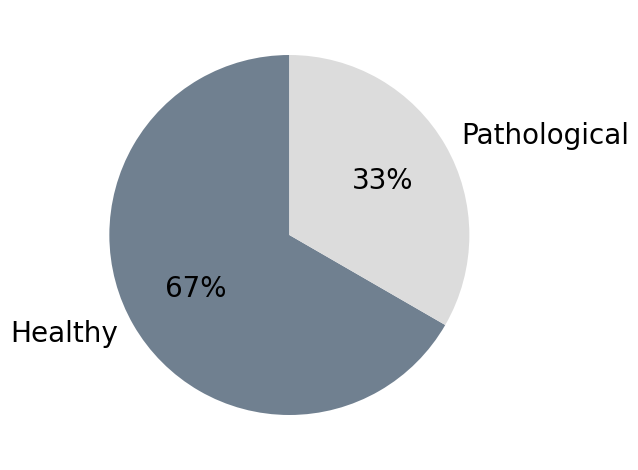

In [37]:
# Create a pie chart of the distribution
incorrect_data = dataframes['diagnosis_df'].iloc[incorrect_idx]

# Replace not "healthy" with pathological
def replace_diagnosis(value):
    if value != 'healthy':
        return 'pathological'
    return value

updated_data = incorrect_data['diagnosis'].apply(replace_diagnosis)

# Plot the pie chart
plt.pie(
    updated_data.value_counts(),
    labels = ["Healthy", "Pathological"],
    colors = ["slategrey", "gainsboro"],
    autopct = "%.0f%%",
    startangle = 90,
    textprops={'fontsize': 20},
)
# plt.title("SVM - Incorrect Prediction Labels", y=0.9)
plt.ylabel('')

# Save the figure
plt.tight_layout()
plt.savefig(f'../images/rfc_incorrect_predictions.png',
            transparent = True,
            bbox_inches = 'tight'
           )

# Display the plot
plt.show()